In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [46]:
train_df = pd.read_csv("/kaggle/input/human-activity-recognition-with-smartphones/train.csv")
test_df = pd.read_csv("/kaggle/input/human-activity-recognition-with-smartphones/test.csv")

print(train_df.shape)
print(test_df.shape)

print(train_df.columns)


(7352, 563)
(2947, 563)
Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity'],
      dtype='object', length=563)


In [47]:
# 561 columns are sensor features
# "subject" - the person who performed the activity
# "Activity"- Target label

train_df[["subject","Activity"]]

,subject,Activity
0,1,STANDING
1,1,STANDING
2,1,STANDING
3,1,STANDING
4,1,STANDING
...,...,...
7347,30,WALKING_UPSTAIRS
7348,30,WALKING_UPSTAIRS
7349,30,WALKING_UPSTAIRS
7350,30,WALKING_UPSTAIRS


## 📊 Understanding the 561 Sensor Features in HAR Dataset

This Human Activity Recognition dataset contains **561 engineered features** per sample (row). These features are derived from raw sensor signals collected using a smartphone.

---

###  1. Raw Sensor Signals

The smartphone uses two sensors:

| Sensor         | Measures             | Axes (Per Signal) |
|----------------|----------------------|-------------------|
| Accelerometer  | Linear acceleration  | X, Y, Z           |
| Gyroscope      | Angular velocity     | X, Y, Z           |

So each time step contains **6 values**:  
`acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z`

---

###  2. Time Window

- Sampling rate: **50 Hz** (i.e., 50 readings/second)
- Time window: **2.56 seconds**
- Number of readings: `50 × 2.56 = 128`

👉 Each window = **128 readings × 6 signals**

---

### 🛠️ 3. Feature Engineering

Instead of using raw readings directly, the dataset includes **precomputed features** such as:

| Feature Type        | Description |
|---------------------|-------------|
| `mean()`            | Average over 128 readings |
| `std()`             | Standard deviation |
| `mad()`             | Median absolute deviation |
| `energy()`          | Signal energy |
| `max()`, `min()`    | Maximum, minimum values |
| `entropy()`         | Measure of randomness |
| `correlation()`     | Relation between signals |
| `angle()`           | Angle between vectors |
| ...                 | (many more) |

---

### ⚙️ 4. Signal Domains Used

- **Time-domain signals** like `tBodyAcc`, `tBodyGyro`
- **Frequency-domain signals** using FFT (Fourier Transform) like `fBodyAcc`
- **Magnitude signals** like `tBodyAccMag`, `fBodyGyroMag`
- **Jerk signals** (rate of change of acceleration)

---

### 🧮 5. Total Features

| Feature Group | Approx. Count |
|---------------|----------------|
| Time-domain features | ~220 |
| Frequency-domain features | ~300 |
| Magnitude & angle features | ~30 |
| **Total** | **561 features** |

Each row represents **1 time window** and contains 561 features + 1 activity label.

---

### ✅ Final Data

- **Shape**: `(num_samples, 561)`
- **Label column**: `Activity`
- Already **normalized, windowed, and split** into train/test

---

### 🔍 Example Feature Names

```text
tBodyAcc-mean()-X
tBodyAcc-std()-Y
tBodyGyro-energy()-Z
fBodyAcc-bandsEnergy()-1,8
angle(tBodyAccMean,gravity)


In [48]:
# Drop 'subject' and 'Activity' from features
#'subject': this column is just the ID of the person (not useful for learning).
#'Activity': target column
X_train = train_df.drop(['subject', 'Activity'], axis=1).values
y_train = train_df['Activity'].values

X_test = test_df.drop(['subject', 'Activity'], axis=1).values
y_test = test_df['Activity'].values

# .values converted df to numpy arrays which is required for frameworks

In [49]:
# Reshape input features for CNN + LSTM: (samples, timesteps, features)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [50]:
# Encode output labels

le = LabelEncoder()

# le.fit_transform : Learns the mapping from text labels → integers using the training data and 
# applies mapping to the data
y_train_enc = le.fit_transform(y_train)

# le.transform : This uses the same mapping learned from y_train.
y_test_enc = le.transform(y_test)

# One-hot encoding
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# Print classes
print("Activity Labels:", le.classes_)

Activity Labels: ['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


In [51]:
print("Training set activity counts :\n", pd.Series(y_train).value_counts())
print("\nTest set activity counts :\n", pd.Series(y_test).value_counts())

Training set activity counts :
 LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64

Test set activity counts :
 LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: count, dtype: int64


In [52]:
X_train.shape

(7352, 561, 1)

In [53]:
# FLow = Conv1D → MaxPooling → Dropout → LSTM → Dense
model = Sequential()

# CNN layer (Extract local features)
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# LSTM layer (Captures temporal dependencies)
model.add(LSTM(100,return_sequences=False))
model.add(Dropout(0.3))

# Fully connected layers
model.add(Dense(100, activation='relu'))
model.add(Dense(6, activation='softmax'))  # 6 classes

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 559, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 279, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 279, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 100)                 │          66,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │             606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,962 (300.63 KB)

 Trainable params: 76,962 (300.63 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8839 - loss: 0.3154 - val_accuracy: 0.8514 - val_loss: 0.4231
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8769 - loss: 0.3084 - val_accuracy: 0.8378 - val_loss: 0.4739
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8805 - loss: 0.3247 - val_accuracy: 0.8609 - val_loss: 0.3833
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8904 - loss: 0.2846 - val_accuracy: 0.8738 - val_loss: 0.3574
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8889 - loss: 0.2906 - val_accuracy: 0.8521 - val_loss: 0.4243
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8919 - loss: 0.2899 - val_accuracy: 0.8629 - val_loss: 0.3850
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8979 - loss: 0.2609 - val_accuracy: 0.8744 - val_loss: 0.3561
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9113 - loss: 0.2441 - val_accu

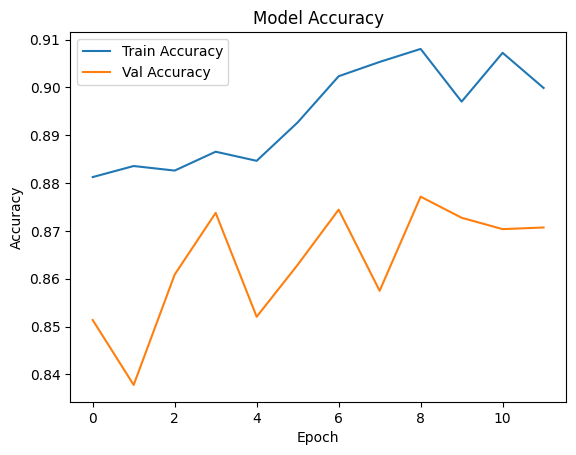

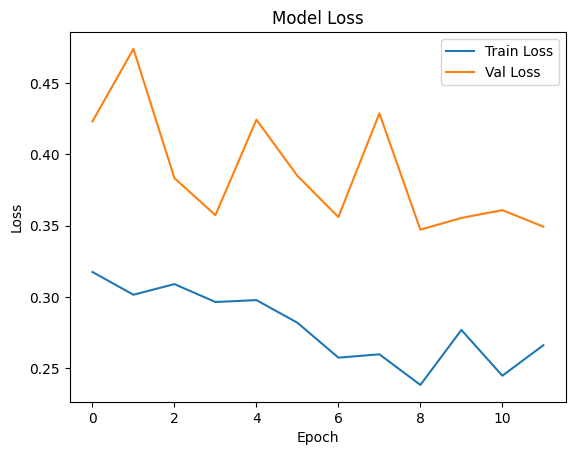

In [56]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [58]:
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc}")
print(f"Test Loss: {loss}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8580 - loss: 0.3743
Test Accuracy: 0.8771632313728333
Test Loss: 0.3472396433353424


In [59]:
# saving the model
model.save('har_cnn_lstm_model.h5')

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


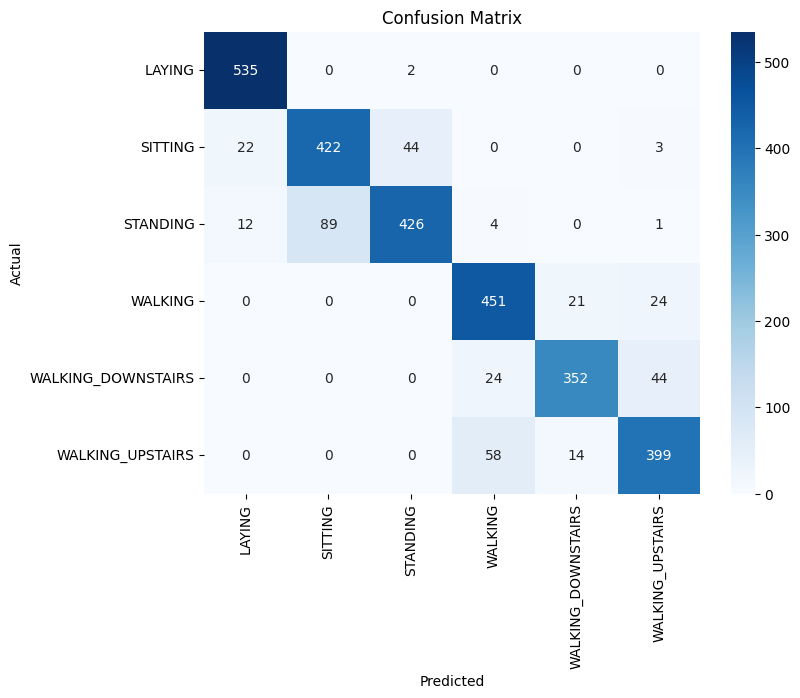

                    precision    recall  f1-score   support

            LAYING       0.94      1.00      0.97       537
           SITTING       0.83      0.86      0.84       491
          STANDING       0.90      0.80      0.85       532
           WALKING       0.84      0.91      0.87       496
WALKING_DOWNSTAIRS       0.91      0.84      0.87       420
  WALKING_UPSTAIRS       0.85      0.85      0.85       471

          accuracy                           0.88      2947
         macro avg       0.88      0.88      0.88      2947
      weighted avg       0.88      0.88      0.88      2947



In [73]:
# Predict
y_pred_prob = model.predict(X_test)

# confusion_matrix() and classification_report() require class labels as integers, not one-hot arrays.
# np.argmax(..., axis=1) efficiently converts one-hot encoded arrays into class labels.


y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_cat, axis=1)


# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=le.classes_))


In [61]:
model.save("har_cnn_lstm_model.h5")